🏗️ IMPLEMENTAR TRANSFORMER DO ZERO (PYTHON PURO)

Sem PyTorch, TensorFlow etc.
Só matemática.

📌 Estrutura que construiremos:

1 - embeddings
2 - positional encoding
3 - self-attention
4 - feedforward
5 - encoder layer
6 - stacking

📌 Operações básicas
Multiplicação matricial

In [9]:
def matmul(A, B):
    result = [[0]*len(B[0]) for _ in range(len(A))]
    for i in range(len(A)):
        for j in range(len(B[0])):
            for k in range(len(B)):
                result[i][j] += A[i][k]*B[k][j]
    return result

Softmax

In [11]:
import math

def softmax_row(row):
    exps = [math.exp(x) for x in row]
    s = sum(exps)
    return [e/s for e in exps]

📌 Self-attention

In [13]:
def transpose(M):
    return list(map(list, zip(*M)))

def scale_matrix(M, scalar):
    return [[x/scalar for x in row] for row in M]

def apply_softmax(M):
    return [softmax_row(row) for row in M]

def self_attention(X, Wq, Wk, Wv):
    Q = matmul(X, Wq)
    K = matmul(X, Wk)
    V = matmul(X, Wv)

    KT = transpose(K)
    scores = matmul(Q, KT)

    dk = len(K[0])
    scores = scale_matrix(scores, math.sqrt(dk))

    A = apply_softmax(scores)

    Z = matmul(A, V)
    return Z

📌 Feedforward network

Duas camadas lineares + ReLU.

In [15]:
def relu(x):
    return max(0, x)

def feedforward(X, W1, W2):
    H = matmul(X, W1)
    H = [[relu(v) for v in row] for row in H]
    return matmul(H, W2)

📌 Encoder layer

In [17]:
def encoder_layer(X, Wq, Wk, Wv, W1, W2):
    att = self_attention(X, Wq, Wk, Wv)
    ff = feedforward(att, W1, W2)
    return ff

📌 Transformer encoder

In [19]:
def transformer_encoder(X, layers):
    for layer in layers:
        X = encoder_layer(X, *layer)
    return X

🧪 2. Testar o código

O modelo precisa de três coisas:

dados de entrada (matriz X)

pesos (Wq, Wk, Wv, W1, W2)

execução do encoder

✅ Passo 1 — criar uma frase tokenizada

Vamos usar 4 tokens com embedding dimensão 4.

In [31]:
X = [
    [1, 0, 1, 0],   # token 1
    [0, 1, 0, 1],   # token 2
    [1, 1, 0, 0],   # token 3
    [0, 0, 1, 1]    # token 4
]

✅ Passo 2 — criar pesos aleatórios

Sem numpy — vamos gerar manualmente.

In [34]:
import random

def random_matrix(rows, cols):
    return [[random.uniform(-1,1) for _ in range(cols)] for _ in range(rows)]

Agora definimos dimensões:

In [39]:
d_model = 4
d_k = 4
d_ff = 6

Pesos:

In [43]:
Wq = random_matrix(d_model, d_k)
Wk = random_matrix(d_model, d_k)
Wv = random_matrix(d_model, d_k)

W1 = random_matrix(d_k, d_ff)
W2 = random_matrix(d_ff, d_model)

✅ Passo 3 — montar camada

In [45]:
layer = (Wq, Wk, Wv, W1, W2)
layers = [layer]   # uma camada só

✅ Passo 4 — rodar Transformer

In [52]:
output = transformer_encoder(X, layers)

✅ Passo 5 — visualizar resultado

In [58]:
for row in output:
    print([round(v, 3) for v in row])

[0.294, -1.333, 0.79, 0.47]
[0.363, -1.679, 1.098, 0.675]
[0.338, -1.524, 0.955, 0.584]
[0.32, -1.493, 0.937, 0.564]


Isso significa:

👉 o modelo transformou representações considerando relações entre tokens.

🧠 4. Validar matematicamente se está correto

Propriedades esperadas:

✔ saída dimensão igual entrada
✔ valores diferentes da entrada
✔ mudança em um token afeta todos
✔ pesos softmax somam 1 por linha

In [63]:
Q = matmul(X, Wq)
K = matmul(X, Wk)

KT = transpose(K)
scores = matmul(Q, KT)

dk = len(K[0])
scores = scale_matrix(scores, math.sqrt(dk))

In [65]:
A = apply_softmax(scores)
print(sum(A[0]))

1.0000000000000002


In [67]:
for i, row in enumerate(A):
    print(i, sum(row))

0 1.0000000000000002
1 1.0
2 1.0
3 1.0


Todas as linhas devem somar ~1.

Isso prova que softmax está correto.

In [69]:
print("scores:")
for r in scores:
    print(r)

print("\nattention weights:")
for r in A:
    print(r)

scores:
[0.7125825936326802, 0.039155851132483425, 0.09815608097241141, 0.6535823637927521]
[-0.5846683550693962, 0.06150154301447563, 0.20374083058146494, -0.7269076426363856]
[-0.0902925539497873, -0.1336315214662327, 0.02097908491247466, -0.24490316032849466]
[0.2182067925130713, 0.23428891561319176, 0.2809178266414017, 0.1715778814848613]

attention weights:
[0.33404421587589184, 0.17034854870418567, 0.180701564293849, 0.31490567112607365]
[0.1673492890688991, 0.31933894990052175, 0.3681506999699061, 0.14516106106067314]
[0.2543213039172209, 0.2435347094108621, 0.28425453379354937, 0.2178894528783677]
[0.24780858050178625, 0.2518260870274284, 0.2638465355652551, 0.23651879690553024]


Observe:

✔ scores podem ser negativos ou grandes
✔ attention vira probabilidades
✔ cada linha é distribuição sobre tokens

Isso é fundamental para entender LLMs.

⚙️ Implementação no seu código Python puro

Vamos criar função máscara.

📌 Criar máscara triangular

In [78]:
import math

def causal_mask(n):
    M = []
    for i in range(n):
        row = []
        for j in range(n):
            if j > i:
                row.append(-1e9)   # aproxima -∞
            else:
                row.append(0)
        M.append(row)
    return M

📌 Somar máscara aos scores

In [84]:
def add_matrices(A, B):
    return [
        [A[i][j] + B[i][j] for j in range(len(A[0]))]
        for i in range(len(A))
    ]

📌 Self-attention com máscara causal

In [87]:
def self_attention_causal(X, Wq, Wk, Wv):
    Q = matmul(X, Wq)
    K = matmul(X, Wk)
    V = matmul(X, Wv)

    KT = transpose(K)
    scores = matmul(Q, KT)

    dk = len(K[0])
    scores = scale_matrix(scores, math.sqrt(dk))

    M = causal_mask(len(scores))
    scores = add_matrices(scores, M)

    A = apply_softmax(scores)
    Z = matmul(A, V)
    return Z, A

🔬 Como testar se está funcionando

In [92]:
Z, A = self_attention_causal(X, Wq, Wk, Wv)

for row in A:
    print(row)

[1.0, 0.0, 0.0, 0.0]
[0.34385316033785196, 0.656146839662148, 0.0, 0.0]
[0.32517309075192585, 0.31138144129002276, 0.36344546795805155, 0.0]
[0.24780858050178625, 0.2518260870274284, 0.2638465355652551, 0.23651879690553024]


🧠 Interpretação profunda

Máscara causal transforma self-attention em:

modelo autoregressivo fatorizado

Ou seja, o modelo aprende:

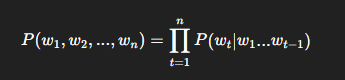

Isso é modelagem probabilística sequencial.

⚡ Por que isso é ESSENCIAL para modelos geradores

Sem máscara:

✔ modelo vê resposta correta durante treino
✔ perda artificialmente baixa
✔ não aprende geração real

Com máscara:

✔ aprende dependência temporal
✔ consegue gerar token por token
✔ comportamento de linguagem natural

🧠 Insight

Máscara causal não é apenas “bloqueio”.

Ela define a estrutura do grafo computacional do modelo.

Sem máscara → grafo totalmente conectado
Com máscara → grafo direcionado no tempo

Isso muda completamente a distribuição modelada.

🎯 Resumo em uma frase

Máscara causal impede que um token veja o futuro durante self-attention, permitindo modelagem probabilística autoregressiva correta para geração de texto.